# Parametric Anomaly Detection

### Financial Data Science II Final Project

Rohit Kumar Bose (*rohitbos*)

Find anomalies in SEC dataset found [here](https://www.sec.gov/opa/data/market-structure/marketstructuredownloadshtml-by_security).

⚠ On average, this notebook takes ~5 minutes to run.

In [1]:
import math
import zipfile
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib as mpl
import scipy.stats as ss
import matplotlib.pyplot as plt

from scipy import optimize
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

sns_palette = {
    'ETF': 'blue',
    'Stock': 'orange'
}

In [2]:
# To run from Google Colab
# from google.colab import drive

# drive.mount('/content/gdrive', force_remount=True)
# root_dir = '/content/gdrive/My Drive/'

In [3]:
# Use this cell to run locally
root_dir = './'

Set the quarter and year to use

In [4]:
quar = 1
year = 2016

zipfname = 'individual_security_'+str(year)+'_q'+str(quar)+'.zip'
csvfname = 'q'+str(quar)+'_'+str(year)+"_all.csv"

with zipfile.ZipFile(root_dir+zipfname) as archive:
    raw_data = pd.read_csv(archive.open(csvfname))

## Pre-processing

Make a structure to store all anomalous indices.

In [5]:
# Record outliers in this dictionary
# Key is dataframe index. This maps to another dictionary which currently only contains 'REASON'
MASTER_OUTLIERS = {}

def record_outlier(index, reason):
    if index not in MASTER_OUTLIERS:
        MASTER_OUTLIERS[index] = {'REASON': set()}
    MASTER_OUTLIERS[index]['REASON'].add(reason)

In [6]:
# Numeric columns already in the dataset
original_columns = [
    "LitVol('000)", "OrderVol('000)", 'Hidden', 'TradesForHidden', "HiddenVol('000)", "TradeVolForHidden('000)",
    'Cancels', 'LitTrades', 'OddLots', 'TradesForOddLots', "OddLotVol('000)", "TradeVolForOddLots('000)"
]

### Clean

In [7]:
data = raw_data.copy()

# Drop rank columns
data.drop(['McapRank', 'TurnRank', 'VolatilityRank', 'PriceRank'], axis=1, inplace=True)
# Convert date column to date type
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
# Mark categorical columns as such
for col in ['Security', 'Ticker']:
    data[col] = data[col].astype('category')

# Drop duplicates
data.drop_duplicates(subset=['Date', 'Security', 'Ticker'], keep='last', inplace=True)

# Replace negative values with null, as they are meaningless for features such as trade volume and number of trades
data[original_columns] = data[original_columns].where(data[original_columns] >= 0, np.nan)

# Remove rows which have null values in all numeric columns
data.dropna(how='all', subset=original_columns, axis=0, inplace=True)

### Null analysis

Instead of imputing null values, we assume that other data points will enable us to determine the distribution effectively.

In [8]:
# Display non-zero count of nulls per column
null = data[original_columns].isnull().sum().sort_values(ascending=False)
null[null != 0]

HiddenVol('000)            188
Hidden                      86
TradesForHidden              4
TradeVolForHidden('000)      4
dtype: int64

## Rate/Ratio features



We construct some rate/ratio features, following the definitions given in the README file.

These features are invariant across individual securities since they are in a relative scale. So it makes sense to use them.

- We treat 0/0 as NULL because it does not have any information.
- non-0/0:
    - CancelTradeRatio = Cancels/(LitTrades+1). Cancels are considerably larger than LitTrades, so this transformation is fair.
    - Others: NULL, because by definition, their numerator cannot be more than the denominator.

In [9]:
data[['Cancels', 'LitTrades']].describe()

,Cancels,LitTrades
count,3.233100e+05,323310.000000
mean,1.250701e+05,3675.989697
std,3.667731e+05,11809.680613
min,0.000000e+00,0.000000
25%,6.299000e+03,23.000000
50%,2.888700e+04,399.000000
75%,9.492525e+04,2731.000000
max,1.713805e+07,840309.000000


In [10]:
metrics_columns = [
    'CancelTradeRatio', 'TradeOrderRate', 'HiddenRate',
    'HiddenVolRate', 'OddLotRate', 'OddLotVolRate'
]
percent_columns = metrics_columns[1:] # All metrics except CancelTradeRatio

In [11]:
# Metrics

data['CancelTradeRatio'] = data['Cancels']/(data['LitTrades']+1)

# These features should lie between 0 and 100.
data['TradeOrderRate'] = 100*(data['LitVol(\'000)']/data['OrderVol(\'000)']).replace(np.inf, np.nan)
data['HiddenRate'] = 100*(data['Hidden']/data['TradesForHidden']).replace(np.inf, np.nan)
data['HiddenVolRate'] = 100*(data['HiddenVol(\'000)']/data['TradeVolForHidden(\'000)']).replace(np.inf, np.nan)
data['OddLotRate'] = 100*(data['OddLots']/data['TradesForOddLots']).replace(np.inf, np.nan)
data['OddLotVolRate'] = 100*(data['OddLotVol(\'000)']/data['TradeVolForOddLots(\'000)']).replace(np.inf, np.nan)

In [12]:
data[metrics_columns].describe()

,CancelTradeRatio,TradeOrderRate,HiddenRate,HiddenVolRate,OddLotRate,OddLotVolRate
count,323310.000000,323306.000000,304424.000000,304322.000000,303771.000000,303771.000000
mean,1496.352793,1.811133,20.646555,21.709736,32.034583,13.757511
std,7558.532025,2.262852,18.974528,19.927123,20.706885,16.372037
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.018917,0.108411,8.303422,9.037506,16.666667,3.692967
50%,40.341953,1.331576,14.742015,15.691052,30.069930,10.358686
75%,223.134921,2.686259,26.612455,27.845327,43.843808,18.150639
max,663721.000000,194.340816,100.000000,100.000000,100.000000,100.000000


- *CancelTradeRatio* may require a log transform because it seems to have a wide range of values, with more values in the greater side.
- *TradeOrderRate* should be constrained within 0 and 100.

In [13]:
# From the percentage columns, weed out values which are out of range, because they are invalid
for col in percent_columns:
    indices = list(data[(data[col] < 0) | (data[col] > 100)].index)
    data = data.loc[~data.index.isin(indices)]

In [14]:
numeric_columns = original_columns + metrics_columns

## Analysis

#### Metrics Column Statistics

In [15]:
metrics_zero = (data[metrics_columns] == 0).astype(int).sum(axis=0).rename('ZeroCount').to_frame()
metrics_zero['ZeroRatio'] = metrics_zero['ZeroCount']/len(data)
metrics_null = data[metrics_columns].isnull().sum().sort_values(ascending=False).rename('NullCount').to_frame()
metrics_null['NullRatio'] = metrics_null['NullCount']/len(data)
metrics_stats = pd.concat([metrics_zero, metrics_null], axis=1)
metrics_stats

,ZeroCount,ZeroRatio,NullCount,NullRatio
CancelTradeRatio,38,0.000118,0,0.000000
TradeOrderRate,23091,0.071421,4,0.000012
HiddenRate,17722,0.054815,18886,0.058415
HiddenVolRate,17583,0.054385,18988,0.058730
OddLotRate,13414,0.041490,19538,0.060432
OddLotVolRate,13414,0.041490,19538,0.060432


***CancelTradeRatio***

- Only *CancelTradeRatio* seems to be a candidate where the zeros can be anomalous, as the other zeros are nearly 4-5% of the entire dataset.

***Others***

- Since in other rate features, nearly 4-5% are zeros, they are very unlikely to be anomalies.
- But we do need to consider them in the univariate analysis (with appropriate transformation if needed) as otherwise our distribution could be distorted.

---

## Univariate Analysis

- Plot the distribution of data to get a preliminary understanding of the distribution of each feature.
- Note that we can afford to ignore nulls, but we should not ignore zeros.
- This is because even in the presence of nulls, the remaining datapoints would give a close-enough distribution. But zeros actually contribute to the distribution.

### Original features

Since the numbers are too large, we transform them.
- Given that there are many zero values, we change each data point $x$ to $\log_{10} (1+x)$, so as to not get $-\infty$.
- Mean of original features >> 1, so adding 1 to the already large numbers will not have any considerable difference.

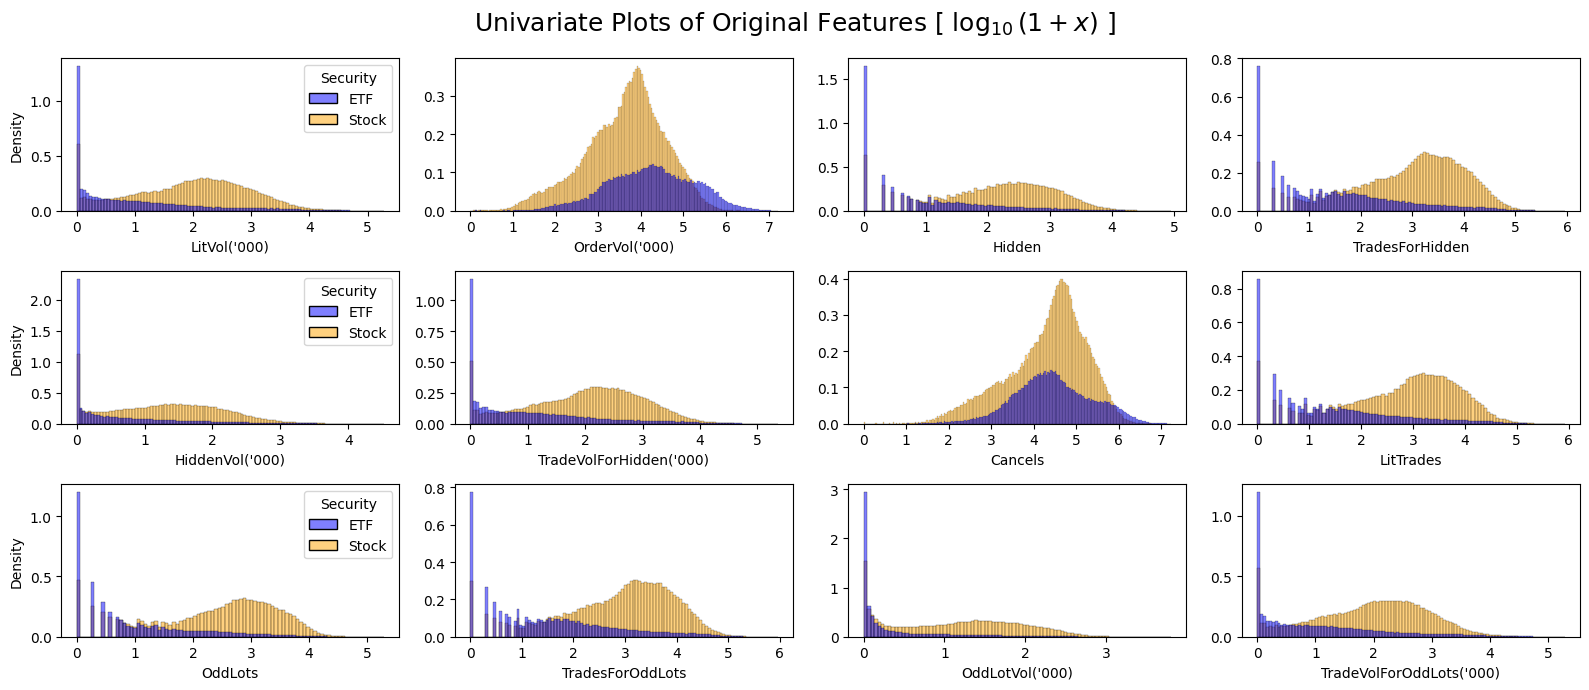

In [16]:
columns = original_columns
ncols = 4
nrows = math.ceil(len(original_columns)/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 7))
fig.suptitle('Univariate Plots of Original Features [ $\log_{10}(1+x)$ ]', fontsize=18)

with np.errstate(divide='ignore', invalid='ignore'):
    for k in range(nrows*ncols):
        i, j = k//ncols, k%ncols
        if k >= len(columns):
            axes[i][j].axis('off')
            continue
        col = columns[k]
        x = np.log10(1+data[col])
        sns.histplot(data, x = x, hue='Security', palette=sns_palette, ax=axes[i][j], stat='density')
        if j != 0:
            axes[i][j].set_ylabel('')
            axes[i][j].get_legend().remove()
        axes[i][j].set_xlabel(col)

plt.tight_layout()
plt.show()

**Observations:**

- Distributions of ETFs and stocks are evidently different. We propose to look at them ***separately***.
- However, there is an abnormal spike for both Stocks and ETFs at 0 (more so for ETFs). It is highly unlikely they are anomalies.
- *Cancels* and *OrderVol('000)* seem to have similar distributions. This elicits a bivariate analysis.

### Additional Features

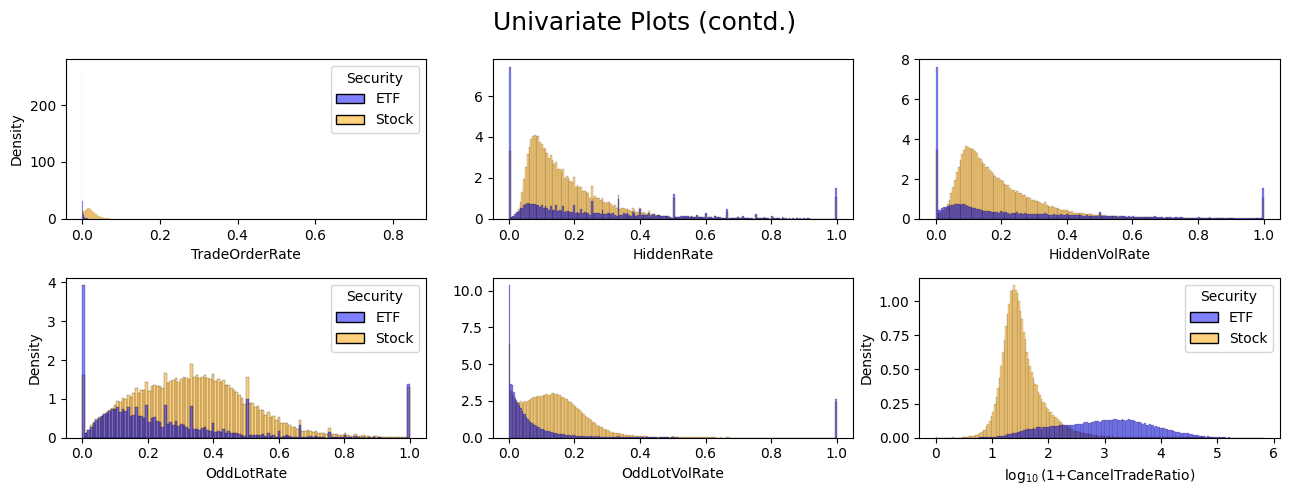

In [17]:
columns = percent_columns
ncols = 3
nrows = math.ceil(len(columns)/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 5))
fig.suptitle('Univariate Plots (contd.)', fontsize=18)

with np.errstate(divide='ignore', invalid='ignore'):
    for k in range(nrows*ncols):
        i, j = k//ncols, k%ncols
        if k >= len(columns):
            continue
        col = columns[k]
        d = data[['Security', col]].dropna()
        x = d[col]/100 # Display on [0,1] scale
        sns.histplot(d, x = x, hue='Security', palette=sns_palette, ax=axes[i][j], stat='density')
        if j != 0:
            axes[i][j].set_ylabel('')
            axes[i][j].get_legend().remove()
        axes[i][j].set_xlabel(f'{col}')

sns.histplot(data, x=np.log10(1+data['CancelTradeRatio']), hue='Security', palette=sns_palette, ax=axes[1][2], stat='density')
axes[1][2].set_xlabel('$\log_{10}$(1+CancelTradeRatio)')

plt.tight_layout()
plt.show()

Even in the rate features, ETFs and stocks have different distributions.

---

### Zero-One Inflated Beta Distribution

- We know that Beta distribution is a good candidate for modelling percentage variables.
- In many of these *Rate* plots, we note that there is a disproportionate number of 0%-s and 100%-s in the data. It is unlikely these are outliers.
- We model this using a special distribution given as follows:

$$
f(x \text{ | } p,q,\alpha,\beta)=
\begin{cases}
    p & \text{if } x = 0 \\
    (1-p)q & \text{if } x = 1 \\
    (1-p)(1-q)\text{Beta}(\alpha, \beta) & \text{otherwise}
\end{cases}
$$

- Parameters are found by MLE.
- We flag points which have low probability of occurring as outliers. Threshold is chosen conservatively as we do not want to flag false positives. We divide the threshold probability by the kurtosis of the distribution so that we do not penalize points in the tail too much.

Reference: https://journal.r-project.org/archive/2015/RJ-2015-019/RJ-2015-019.pdf

In [18]:
# Zero-One Inflated Beta
def zoib(params, x):
    '''
        Takes in a data vector and spits out probabilities
        PDF is defined by params (p, q, a, b)
    '''
    p, q, a, b = params
    z = p*np.where(x == 0, 1, 0) # Zeros are assigned probability p
    o = (1-p)*q*np.where(x == 1, 1, 0) # Ones are assigned probability (1-p)*q
    h = (1-p)*(1-q)*np.where((x != 0) & (x != 1), ss.beta.pdf(x, a, b), 0) # Others
    u = z + o + h
    return u

In [19]:
def percentage_feature_outlier_detection(instr, thresh=1e-10):
    '''
    Inputs:
        instr: Instrument name
        thresh: Threshold probability -- any data point having probability less than this is marked an outlier
    Functionality:
        Finds MLE parameters for the Zero-One Inflated Beta distribution for each percentage feature for each instrument
        Plots:
            - Original data
            - Theoretical distribution
            - Outliers
        Records outliers in the master dictionary
    '''

    columns = percent_columns
    instr_data = data[data['Security'] == instr]

    # Set up figure
    ncols = 3
    nrows = math.ceil(len(columns)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 6))
    fig.suptitle(f'{instr} Percentage Features (Outlier detection)', fontsize=18)

    with np.errstate(divide='ignore', invalid='ignore'):
        for k in tqdm(range(nrows*ncols)):
            i, j = k//ncols, k%ncols
            if k >= len(columns):
                axes[i][j].axis('off')
                continue

            try:
                col = columns[k]
                x = instr_data[col].copy().dropna()/100 # Scale, since support of standard beta is (0, 1)

                # Fit data by using Maximum Likelihood Estimate (MLE)
                init_params = (0.05, 0.05, 0.4, 0.5)
                negloglikelihood = lambda p, x: -np.sum(np.log(zoib(p, x)))
                res = optimize.minimize(
                        fun = negloglikelihood, # cost function
                        x0 = init_params, # initial guess
                        args = (x),
                        bounds=[(0, 1), (0, 1), (None, None), (None, None)],
                        method = 'Nelder-Mead'
                    )

                # Find data points whose probability of occuring is less than threshold
                # We use a dynamic threshold: Divide it by the kurtosis so that we do not penalize tailed distributions much
                data_probs = zoib(res.x, x)
                np_indices = np.where(data_probs < thresh/ss.kurtosis(x, fisher=False))[0]
                outliers = x.values[np_indices]

                # Record outlier in master dictionary
                indices = np.array(x.index)[np_indices]
                for ind in indices:
                    record_outlier(ind, f'Tail point in {col} (Beta model)')

                # Plot theoretical distribution
                p, q, a, b = res.x # Retrieve parameters from MLE output
                lin_sp = [0] + list(np.linspace(0.0001, 0.9999, 1000)) + [1] # Percentages are between 0 and 1.
                beta_probs = (1-p)*(1-q)*ss.beta.pdf(lin_sp[1:-1], a, b)
                probs = [p] + list(beta_probs) + [(1-p)*q]
                axes[i][j].plot(lin_sp, probs, c='green', label='Theoretical Distribution')

                # Plot data
                sns.histplot(x=x, ax=axes[i][j], color=sns_palette[instr], stat='density', label='Data')

                # Mark outliers on graph
                y_outliers = [0 for _ in range(len(outliers))]
                axes[i][j].scatter(x=outliers, y=y_outliers, c='red', label=f'Outlier (#={len(outliers)})')

                # Make graph beautiful
                if j != 0:
                    axes[i][j].set_ylabel('')
                axes[i][j].set_xlabel(f'{col}')
                axes[i][j].set_ylim(-1, min(15, axes[i][j].get_ylim()[1]))
                axes[i][j].legend()
            except:
                logging.warning(f'Issue with showing {str(col)} graph')

    plt.tight_layout()
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

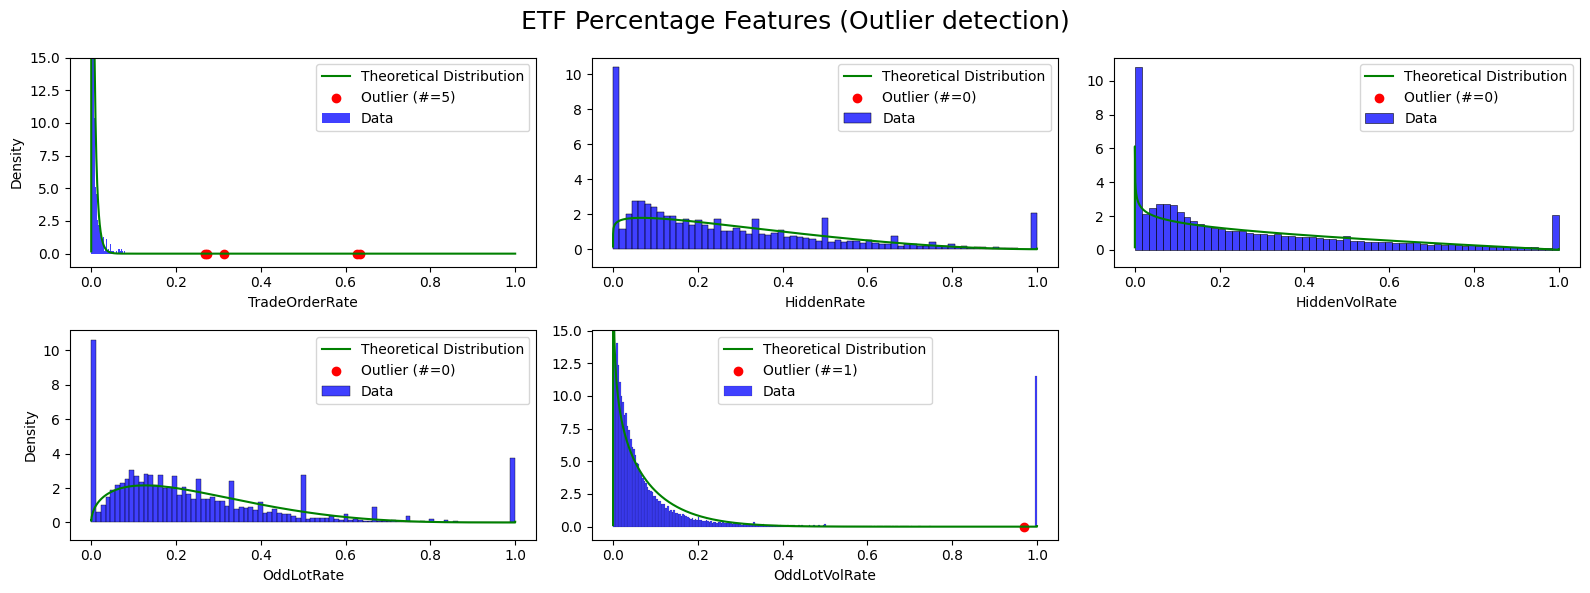

In [20]:
percentage_feature_outlier_detection('ETF')

  0%|          | 0/6 [00:00<?, ?it/s]

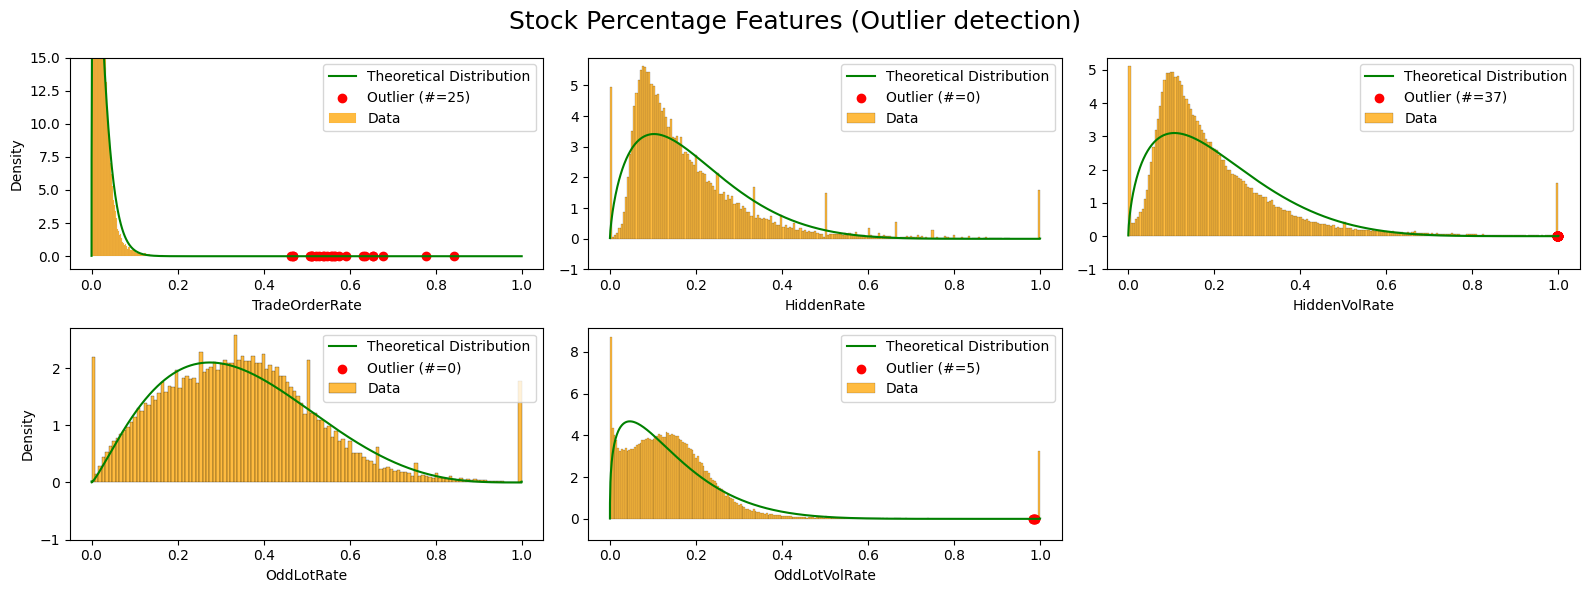

In [21]:
percentage_feature_outlier_detection('Stock')

### Gaussian Mixture Model

We use AIC as the criteria to find the number of components suitable to find a Gaussian Mixture model (GMM) to fit $\log_{10}(1+x)$ features. Parameters of a GMM are found using Expectation-Maximization algorithm. Thankfully, we can use *sklearn* to model it.

- Only do this on *CancelTradeRatio* as it seems to be a feature of interest. From the density plot, it seems to be somewhat normal.
- Select data points in the tails as outliers (which have very low probability).
- We use AIC as model selection criteria (e.g. number of components in the mix).

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [22]:
def gmm_outlier_detection(instr, col='CancelTradeRatio', thresh=1e-7):
    '''
    Inputs:
        instr: Instrument name
        col: Feature name
        thresh: Threshold probability -- any data point having probability less than this is marked an outlier
    Functionality:
        Does a grid search to find the best GMM according to AIC
        Does a log transform on the feature
        Plots:
            - Original data
            - Theoretical GMM distribution
            - Outliers
        Records outliers in the master dictionary
    '''

    try:
        # Prepare data
        instr_data = data[data['Security'] == instr].copy()
        x = (np.log10(1+instr_data[col])).dropna()
        v = x.values

        # Do a grid search by running for different number of components in GMM
        # Limit to 5 components max
        param_grid = {
            'n_components': range(1, 5+1)
        }
        # Use AIC for model selection (note that we maximize negative AIC, so in turn minimize AIC)
        grid_search = GridSearchCV(
            GaussianMixture(),
            param_grid=param_grid,
            scoring=lambda est, x: -est.aic(x),
            n_jobs=-1
        )
        grid_search.fit(v.reshape(-1, 1))

        # Make a dataframe showing AIC with different number of components
        compare = pd.DataFrame(grid_search.cv_results_)[
            ['param_n_components',  'mean_test_score']
        ]
        compare['mean_test_score'] = -compare['mean_test_score'] # Scores have inverted sign
        compare = compare.rename(
            columns={
                'param_n_components': '# Components',
                'mean_test_score': 'AIC',
            }
        ).sort_values(by='AIC')
        print(compare.head().to_string(index=False)) # Display AIC values for reference

        # Set up figure
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        gmm = grid_search.best_estimator_ # Pick best estimator

        # Get the probabilities for each component at each point
        lin_sp = np.linspace(min(v), max(v), 1000)
        data_probs = np.exp(gmm.score_samples(v.reshape(-1, 1))) # Get probability of each data point
        np_indices = np.where(data_probs < thresh)[0]
        outliers = x.values[np_indices]

        # Record outlier in master dictionary
        indices = np.array(x.index)[np_indices]
        for ind in indices:
            record_outlier(ind, f'Tail point in {col} (GMM)')

        # Plot distribution of actual data
        sns.histplot(x=v, ax=ax, stat='density', alpha=0.5, color=sns_palette[instr], label='Data')

        # Plot each component of the GMM. Note that net probability is sum of weighted probabilities from each component.
        mix_density = np.zeros(len(lin_sp))
        for i in range(gmm.n_components):
            component_density = gmm.weights_[i]*ss.norm.pdf(
                lin_sp,
                loc=gmm.means_[i][0],
                scale=np.sqrt(gmm.covariances_[i][0])
            ).flatten()
            ax.plot(lin_sp, component_density, ls='--')
            mix_density += component_density

        # Plot the overall mixture of components
        ax.plot(lin_sp, mix_density, color='black', label='Mixture')

        # Plot outliers
        y_outliers = [0 for _ in range(len(outliers))]
        ax.scatter(x=outliers, y=y_outliers, c='r', label=f'Outlier (#={len(outliers)})')

        # Make graph beautiful
        ax.legend()
        ax.set_xlabel(f'$\log_{{10}}$(1+{col})')
        ax.set_ylim(-0.01, min(15, ax.get_ylim()[1]))
        ax.set_title(f'{instr} GMM Outlier Detection')

        plt.show()
    except:
        logging.warning(f'Issue with showing {str(col)} graph')

# Components          AIC
           3 46967.252731
           4 46980.352573
           5 47019.856713
           2 47054.788684
           1 47562.159957


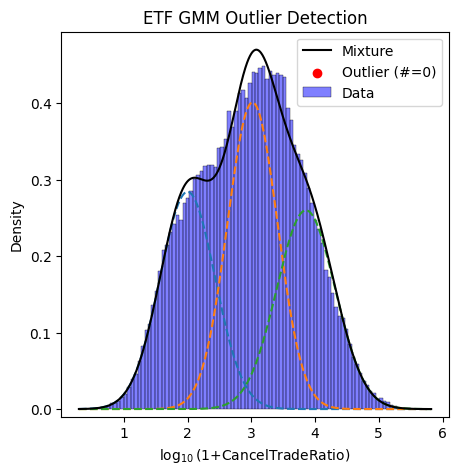

In [23]:
gmm_outlier_detection('ETF')

# Components          AIC
           3 33580.211865
           5 33607.574765
           4 33879.572894
           2 35758.958796
           1 53838.422297


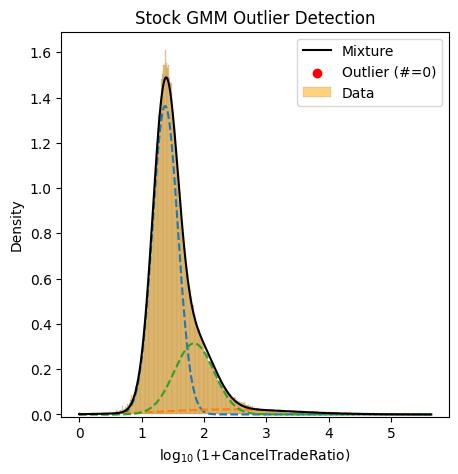

In [24]:
gmm_outlier_detection('Stock')

---

## Bivariate Analysis

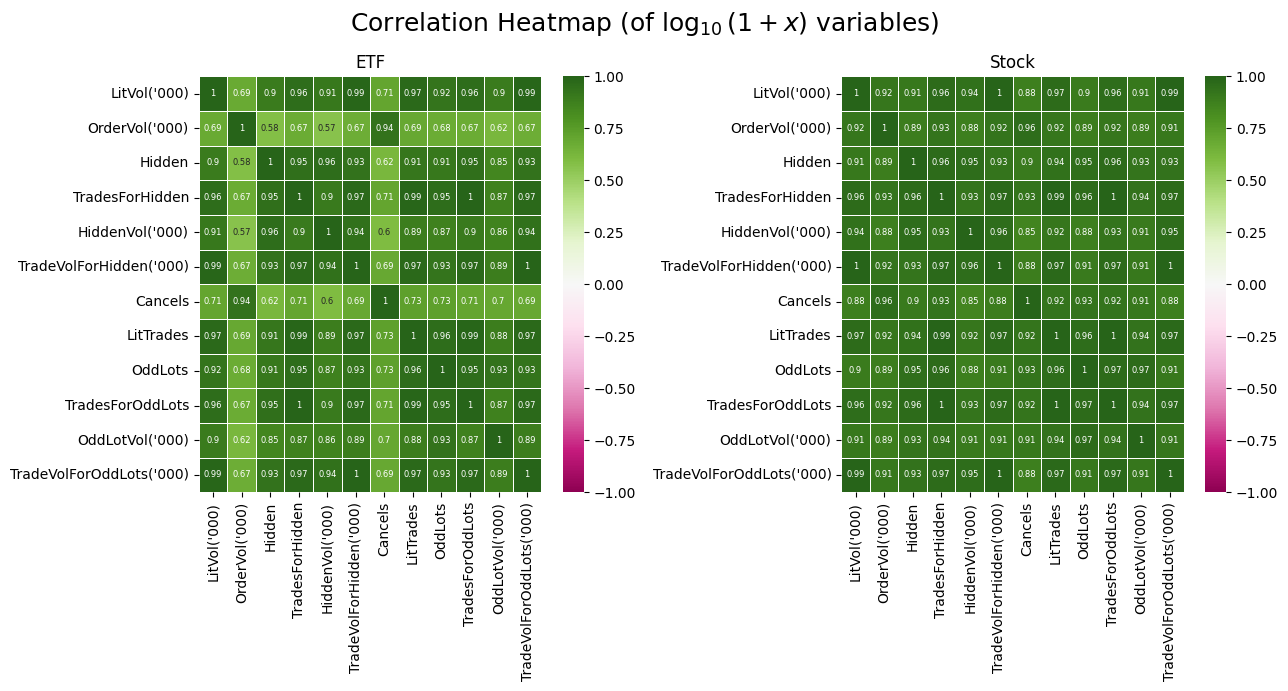

In [25]:
# Plot correlation heatmap

columns = original_columns
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

with np.errstate(divide='ignore', invalid='ignore'):
    plot_data_etf = np.log10(data[data['Security'] == 'ETF'][columns]+1).corr()
    sns.heatmap(plot_data_etf, ax=axes[0], annot=True, linewidths=.5, cmap='PiYG', annot_kws={'fontsize': 6}, vmin=-1, vmax=1)
    axes[0].set_title('ETF')

    plot_data_stock = np.log10(data[data['Security'] == 'Stock'][columns]+1).corr()
    sns.heatmap(plot_data_stock, ax=axes[1], annot=True, linewidths=.5, cmap='PiYG', annot_kws={'fontsize': 6}, vmin=-1, vmax=1)
    axes[1].set_title('Stock')

fig.suptitle('Correlation Heatmap (of $\log_{10}(1+x)$ variables)', fontsize=18)

plt.tight_layout()
plt.show()

The correlation map gives us some idea of how the individual variables are related to each other, but it is not very useful at face value because there is no outright exception.

## Mahalanobis Distance

This is a measure of the distance between a point P and a distribution D.  It weighs the distance calculation according to the statistical variation of each component using the covariance matrix of the observed sample. It measures distance relative to the centroid of the data, which can be thought of as an overall mean for multivariate data.

- It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D.
- It is unitless, scale-invariant, and takes into account the correlations of the data set.
- Larger the value of Mahalanobis distance, more unusual the data point (i.e., the more likely it is to be a multivariate outlier).

- $\text{MD} = \sqrt{ (\vec{x}-\vec{\mu})^T \Sigma^{-1} (\vec{x}-\vec{\mu}) }$.

  - Here, $\vec{x}$ is our data point, $\vec{\mu}$ and $\Sigma$ are the mean and covariance matrix of our data.

- The calculated Mahalanobis distances are compared against a $\chi^2$ distribution with degrees of freedom equal to the number of variables.
- We assume here that the underlying distribution is bivariate normal, which is far from true. However, Mahalanobis distance gives decent results nevertheless, as we will observe in the plots.

Reference: https://www.cfholbert.com/blog/outlier_mahalanobis_distance/

In [26]:
def bivariate_mahalanobis_outlier_detection(instr, column_pairs, pval=.0005):
    '''
    Inputs:
        instr: Instrument name
        column_pairs: Column pairs to fit bivariate distribution on
        pval: Threshold p-value -- Any datapoint lying in the tail of Chi-Square distribution (after 1-pval) portion is marked
    Functionality:
        Finds MLE parameters for the bivariate normal distribution of log transforms of original features for each instrument
        Plots:
            - Original data
            - Theoretical distribution
            - Outliers (according to Mahalanobis distances)
        Records outliers in the master dictionary
    '''

    instr_data = data[data['Security'] == instr]

    # Set up figure
    ncols = 6
    nrows = math.ceil(len(column_pairs)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9))
    fig.suptitle(f'{instr} Bivariate Outlier detection based on Mahalanobis Distance [ $\log_{{10}}(1+x)$ ]', fontsize=18)

    with np.errstate(divide='ignore', invalid='ignore'):
        for k in tqdm(range(nrows*ncols)):
            i, j = k//ncols, k%ncols
            if k >= len(column_pairs):
                axes[i][j].axis('off')
                continue

            try:
                col_pair = column_pairs[k]

                # Prepare data
                d = instr_data[col_pair].copy()
                for col in col_pair:
                    d[col] = np.log10(1+d[col])
                d.dropna(inplace=True)

                v = d.values

                # MLE estimate of bivariate Gaussian parameters
                mean = d.values.mean(axis=0)
                cov = d.cov(ddof=1).values
                cov_inv = np.linalg.inv(cov)

                # Compute Mahalanobis distance of each point from distribution
                MD = cdist(v, mean.reshape(1, -1), metric='mahalanobis', VI=cov_inv).flatten()

                # Threshold
                thresh = ss.chi2.ppf(1-pval, df=2)

                np_indices = np.where(MD > thresh)[0]

                # Record outlier in master dictionary
                indices = np.array(d.index)[np_indices]
                for ind in indices:
                    record_outlier(ind, f'Mahalanobis outlier for {col_pair[0]}, {col_pair[1]}')

                outliers = v[np_indices]

                # Plot the data points
                sns.scatterplot(x=v[:, 0], y=v[:, 1], ax=axes[i][j], s=5, color='black', alpha=0.5)

                # Create a meshgrid to plot the contour plots
                x, y = np.meshgrid(np.linspace(v[:, 0].min()-2, v[:, 0].max()+2, 100),
                                np.linspace(v[:, 1].min()-2, v[:, 1].max()+2, 100))
                xy = np.column_stack([x.ravel(), y.ravel()])

                z = -ss.multivariate_normal.logpdf(xy, mean=mean, cov=cov)
                z = z.reshape(x.shape)

                # Plot the contour plots
                axes[i][j].contourf(x, y, z, levels=np.logspace(0, 3, 10), cmap='viridis', alpha=0.5, norm=mpl.colors.LogNorm())

                # Highlight the outliers
                axes[i][j].scatter(x=outliers[:, 0], y=outliers[:, 1], c='red', alpha=0.5, s=15, label=f'Outlier (#={len(outliers)})')

                # Make graph beautiful
                axes[i][j].set_xlabel(col_pair[0])
                axes[i][j].set_ylabel(col_pair[1])
                axes[i][j].legend()
            except:
                logging.warning(f'Issue with showing {str(col_pair)} graph')

    plt.tight_layout()
    plt.show()

In [27]:
# Column pairs of original columns to see bivariate relationships
# Maybe these have interesting relationships
column_pairs = [
    ['OrderVol(\'000)', 'LitVol(\'000)'],
    ['OrderVol(\'000)', 'HiddenVol(\'000)'],
    ['OrderVol(\'000)', 'TradeVolForHidden(\'000)'],
    ['OrderVol(\'000)', 'OddLotVol(\'000)'],
    ['OrderVol(\'000)', 'TradeVolForOddLots(\'000)'],
    ['OrderVol(\'000)', 'Cancels'],
    ['Hidden', 'Cancels'],
    ['LitTrades', 'Cancels'],
    ['OddLots', 'Cancels'],
    ['HiddenVol(\'000)', 'LitVol(\'000)'],
    ['HiddenVol(\'000)', 'OddLotVol(\'000)'],
    ['OddLots', 'TradesForOddLots'],
    ['OddLots', 'LitTrades'],
    ['OddLots', 'TradesForHidden'],
    ['LitVol(\'000)', 'TradeVolForOddLots(\'000)'],
    ['LitTrades', 'TradesForOddLots'],
    ['LitTrades', 'TradesForHidden']
]

  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\Rohit\AppData\Local\Temp\ipykernel_22860\3217053057.py:74: UserWarning: Log scale: values of z <= 0 have been masked
  axes[i][j].contourf(x, y, z, levels=np.logspace(0, 3, 10), cmap='viridis', alpha=0.5, norm=mpl.colors.LogNorm())


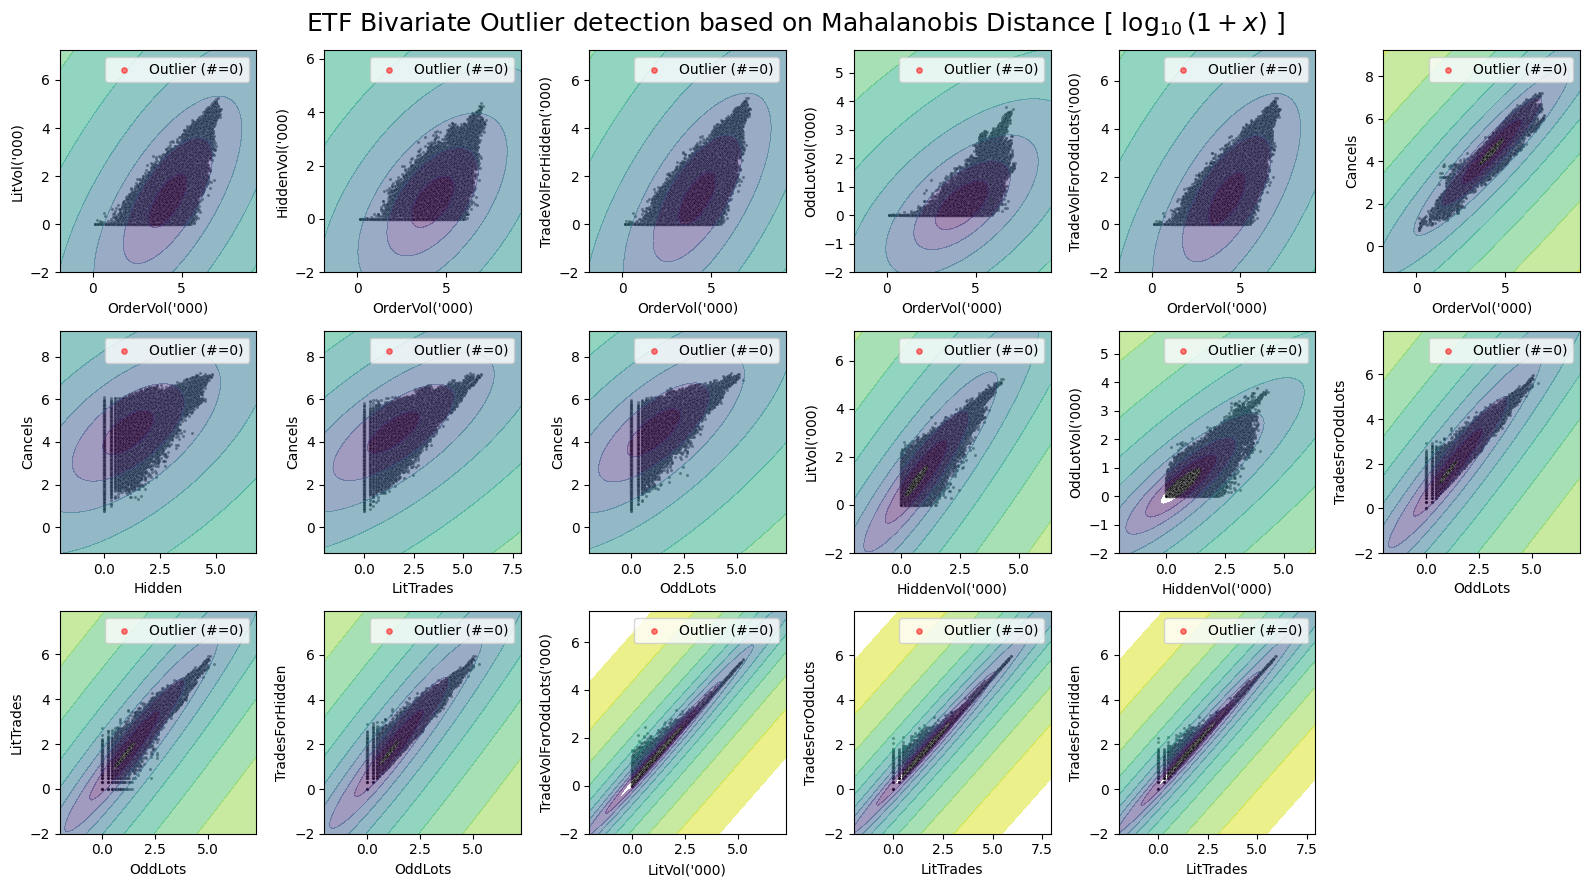

In [28]:
bivariate_mahalanobis_outlier_detection('ETF', column_pairs)

  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\Rohit\AppData\Local\Temp\ipykernel_22860\3217053057.py:74: UserWarning: Log scale: values of z <= 0 have been masked
  axes[i][j].contourf(x, y, z, levels=np.logspace(0, 3, 10), cmap='viridis', alpha=0.5, norm=mpl.colors.LogNorm())
C:\Users\Rohit\AppData\Local\Temp\ipykernel_22860\3217053057.py:74: UserWarning: Log scale: values of z <= 0 have been masked
  axes[i][j].contourf(x, y, z, levels=np.logspace(0, 3, 10), cmap='viridis', alpha=0.5, norm=mpl.colors.LogNorm())
C:\Users\Rohit\AppData\Local\Temp\ipykernel_22860\3217053057.py:74: UserWarning: Log scale: values of z <= 0 have been masked
  axes[i][j].contourf(x, y, z, levels=np.logspace(0, 3, 10), cmap='viridis', alpha=0.5, norm=mpl.colors.LogNorm())


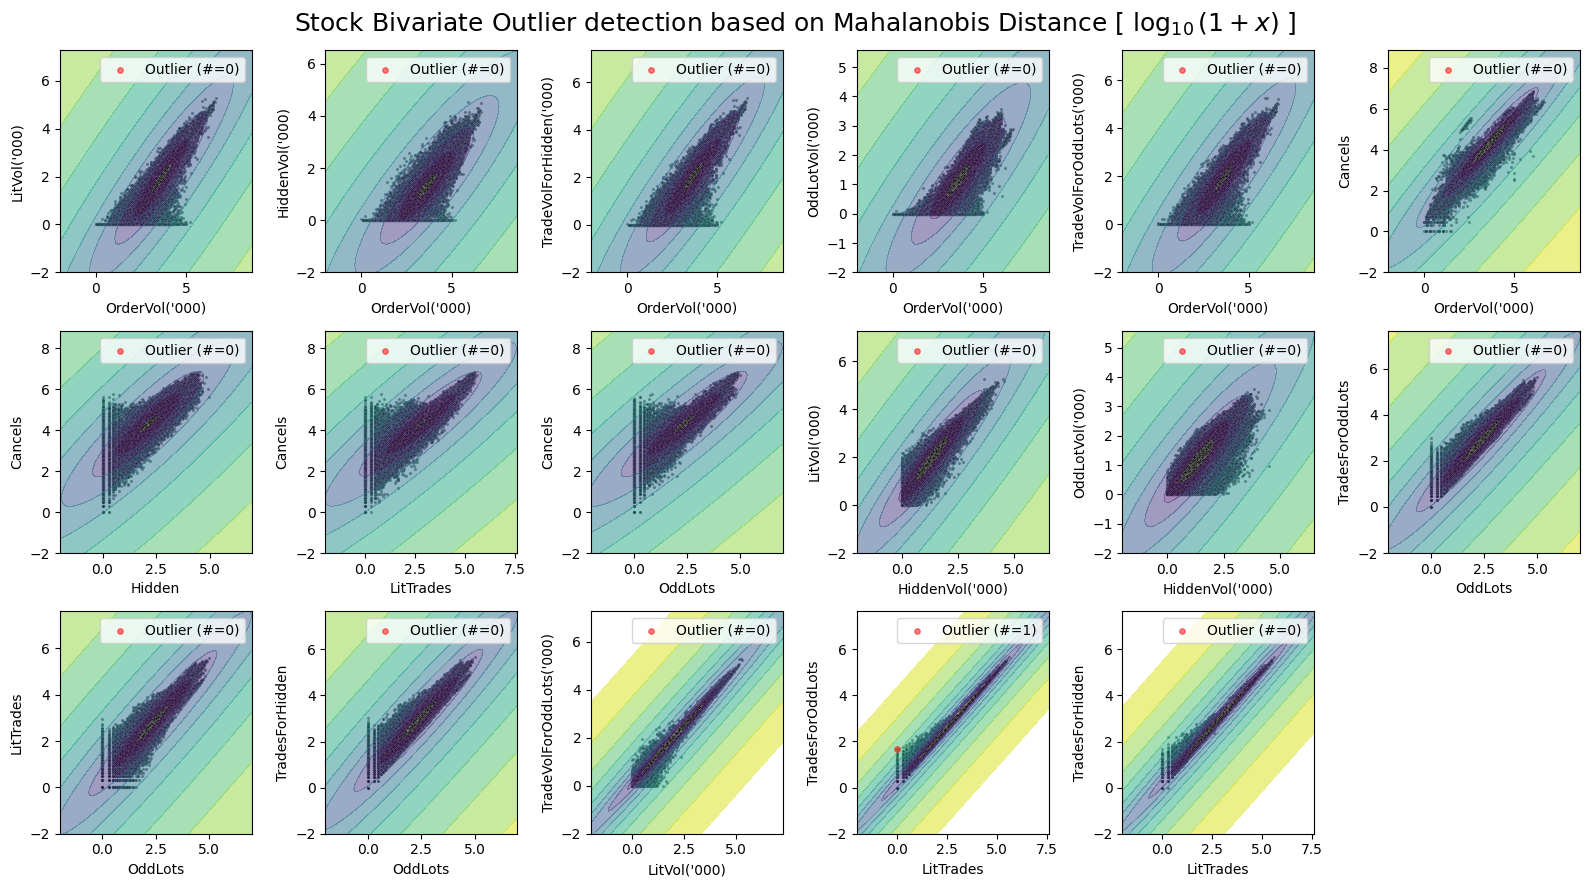

In [29]:
bivariate_mahalanobis_outlier_detection('Stock', column_pairs)

## Anomalous rows

In [30]:
outlier_indices = list(MASTER_OUTLIERS.keys()) # Outlier Indices
percent_outliers = 100*len(MASTER_OUTLIERS)/len(data)
print(f'{percent_outliers:.3f}% ({len(MASTER_OUTLIERS)}/{len(data)}) data are outliers.')

# Final output
raw_data.loc[outlier_indices]

0.023% (74/323308) data are outliers.


,Date,Security,Ticker,McapRank,TurnRank,VolatilityRank,PriceRank,LitVol('000),OrderVol('000),Hidden,TradesForHidden,HiddenVol('000),TradeVolForHidden('000),Cancels,LitTrades,OddLots,TradesForOddLots,OddLotVol('000),TradeVolForOddLots('000)
5105,20160104.0,ETF,TFLO,1.0,3.0,1.0,3.0,2.074,3.274,0.0,2.0,0.000,2.074,9.0,2.0,0.0,2.0,0.000,2.074
42403,20160113.0,ETF,TFLO,1.0,2.0,1.0,4.0,1.250,4.002,0.0,1.0,0.000,1.250,38.0,1.0,0.0,1.0,0.000,1.250
95589,20160128.0,ETF,TFLO,1.0,2.0,1.0,3.0,0.439,0.700,0.0,1.0,0.000,0.439,6.0,1.0,0.0,1.0,0.000,0.439
200303,20160226.0,ETF,BSCG,4.0,4.0,1.0,2.0,684.377,2508.822,143.0,388.0,240.216,924.593,1303.0,245.0,25.0,388.0,0.863,924.593
201557,20160226.0,ETF,TFLO,1.0,3.0,1.0,3.0,3.206,11.988,0.0,5.0,0.000,3.206,58.0,5.0,0.0,5.0,0.000,3.206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55707,20160119.0,Stock,NVR,9.0,6.0,4.0,10.0,12.466,863.617,793.0,2301.0,7.564,20.030,22437.0,1223.0,1829.0,1831.0,15.819,16.019
130067,20160208.0,Stock,NVR,9.0,5.0,5.0,10.0,7.806,1115.107,688.0,1460.0,7.516,15.322,19133.0,556.0,1040.0,1041.0,9.866,9.985
225363,20160304.0,Stock,NVR,9.0,5.0,2.0,10.0,4.059,579.815,831.0,1190.0,6.595,10.654,14938.0,240.0,782.0,783.0,6.712,6.812
235947,20160308.0,Stock,NVR,9.0,5.0,6.0,10.0,4.627,795.959,689.0,1160.0,5.459,10.086,19860.0,291.0,732.0,733.0,6.121,6.221
